Variant using floodfill to segment out shells. Good if saturation values are significantly different and user can provide plausible ranges for manual HSV-based thresholding, but otherwise canny edge detection is a better general solution. 

This version also requires well-cropped images with well defined foreground and background, else floodFill will fail.

Works MUCH better on test 6 but worse on all other test images than Canny edge detection.

TODO: Check if adaptive gaussian thresholding will work on HSV channels well

In [1]:
import os
import cv2 
import copy
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

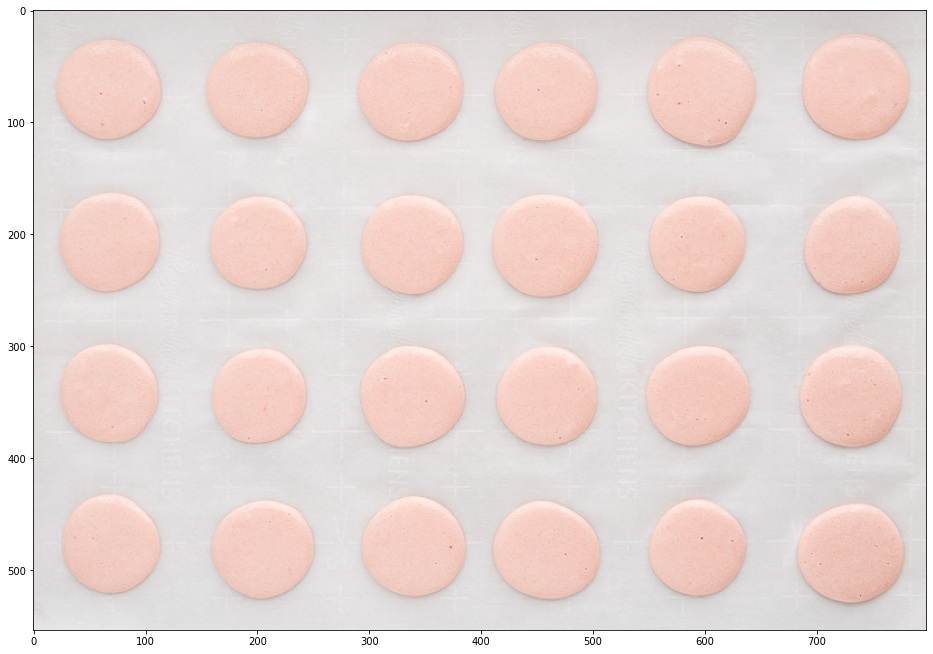

In [2]:
IMAGE_PATH = os.path.join("..", "data", "test-6-cropped.jpg")

# Read image
im = cv2.imread(IMAGE_PATH)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Plot
plt.figure(figsize=(16,16))
plt.imshow(im)

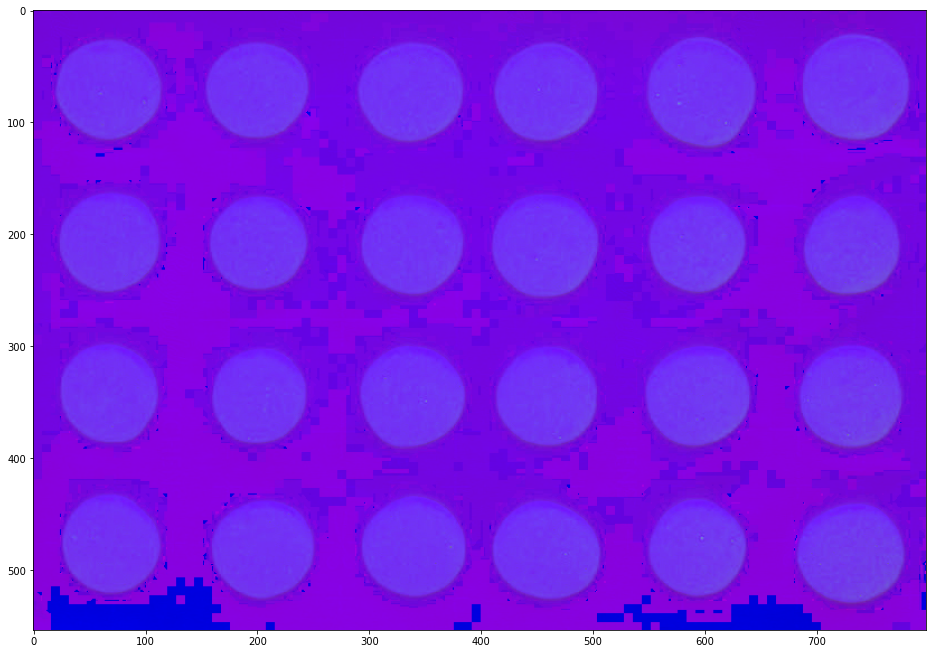

In [3]:
# Convert from RGB to HSV encoding
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(16,16))
plt.imshow(im_hsv)

## Threshold based on manually provided HSV range

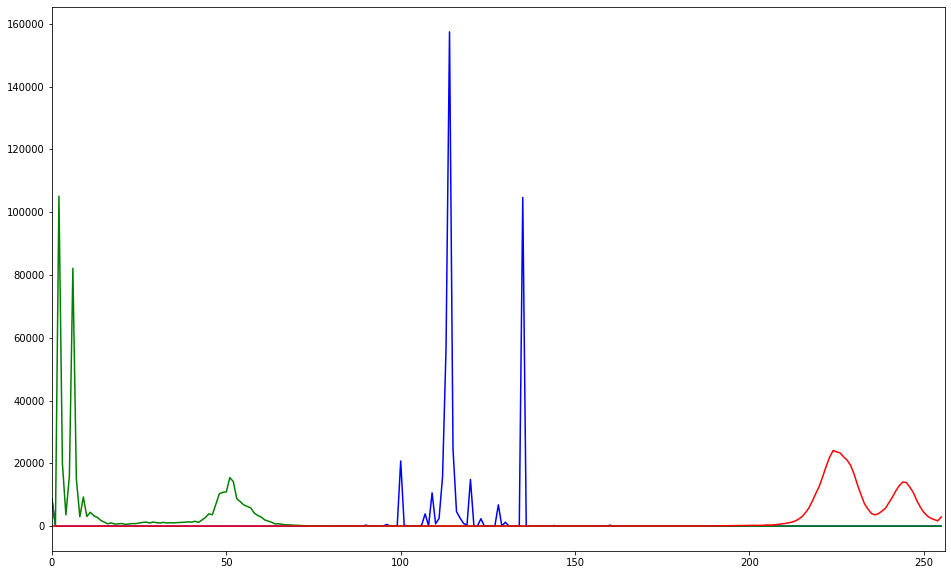

In [4]:
plt.figure(figsize=(16, 10))
COLORS = ('b', 'g', 'r')

for idx, i in enumerate(COLORS):
    hist = cv2.calcHist([im_hsv], [idx], None, [256], [0, 256])
    plt.plot(hist, color=COLORS[idx])
    plt.xlim([0, 256])
    

plt.show()

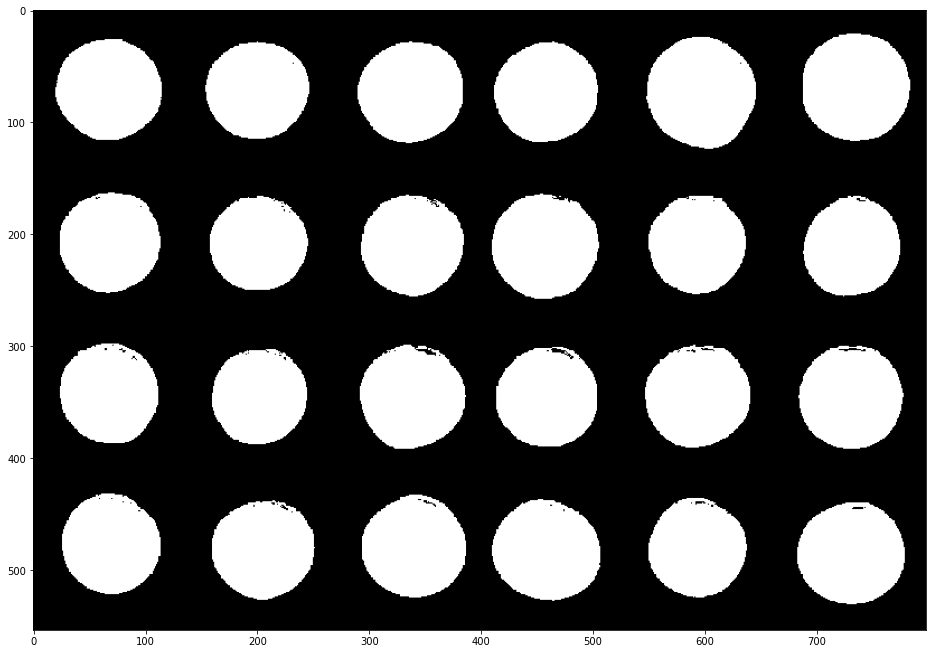

In [5]:
# https://stackoverflow.com/questions/61677816/remove-coins-shadow-using-opencv

low_h, low_s, low_v = 0, 25, 0
high_h, high_s, high_v = 255, 255, 255

threshold = cv2.inRange(im_hsv, (low_h, low_s, low_v), (high_h, high_s, high_v))

plt.figure(figsize=(16,16))
plt.imshow(threshold, cmap='gray')

## Remove shadows with floodFill

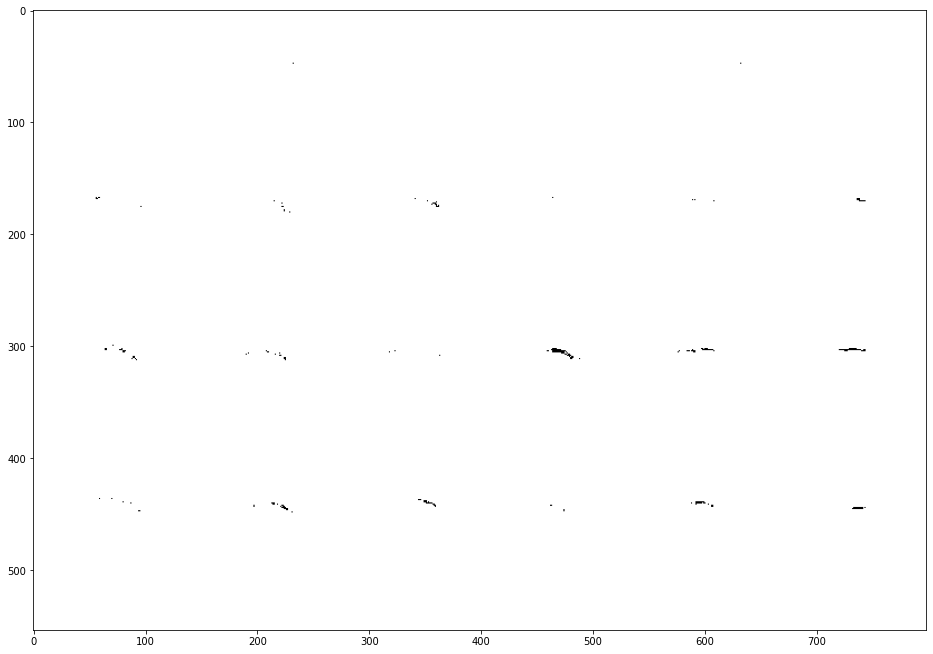

In [6]:
im_floodfill = threshold.copy()
h, w = im_floodfill.shape[:2]

mask = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0, 0), 255)
plt.figure(figsize=(16,16))
plt.imshow(im_floodfill, cmap='gray')

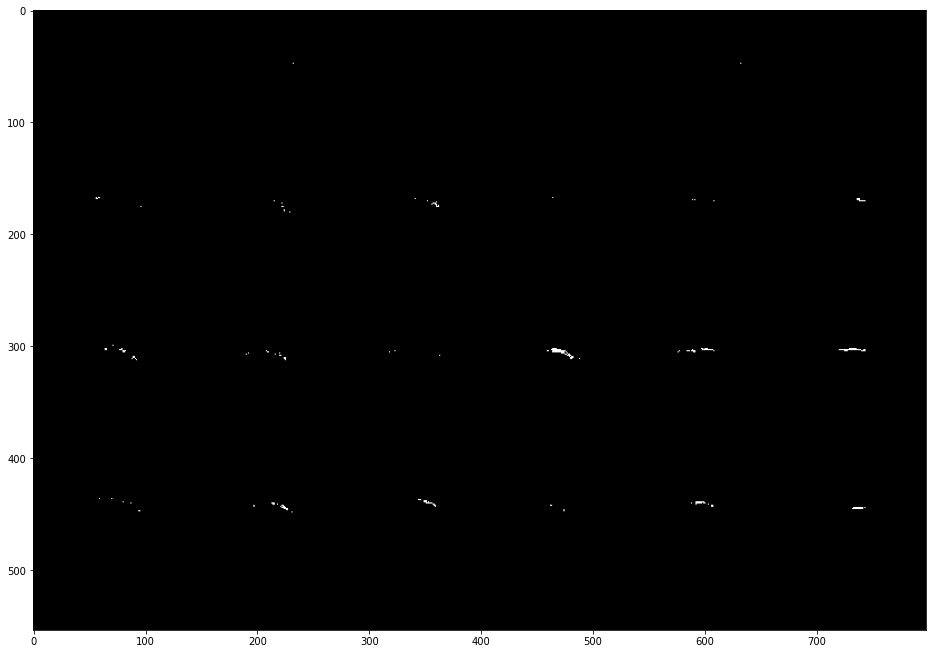

In [7]:
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
plt.figure(figsize=(16,16))
plt.imshow(im_floodfill_inv, cmap='gray')

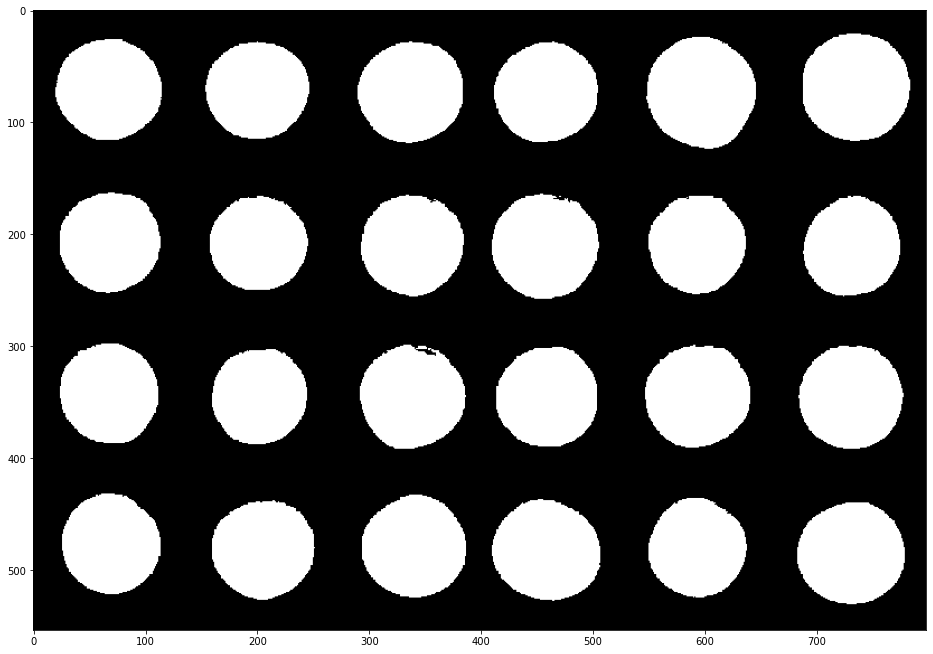

In [8]:
mask = threshold | im_floodfill_inv
plt.figure(figsize=(16,16))
plt.imshow(mask, cmap='gray')

## Find Contours

Detected 25 contours


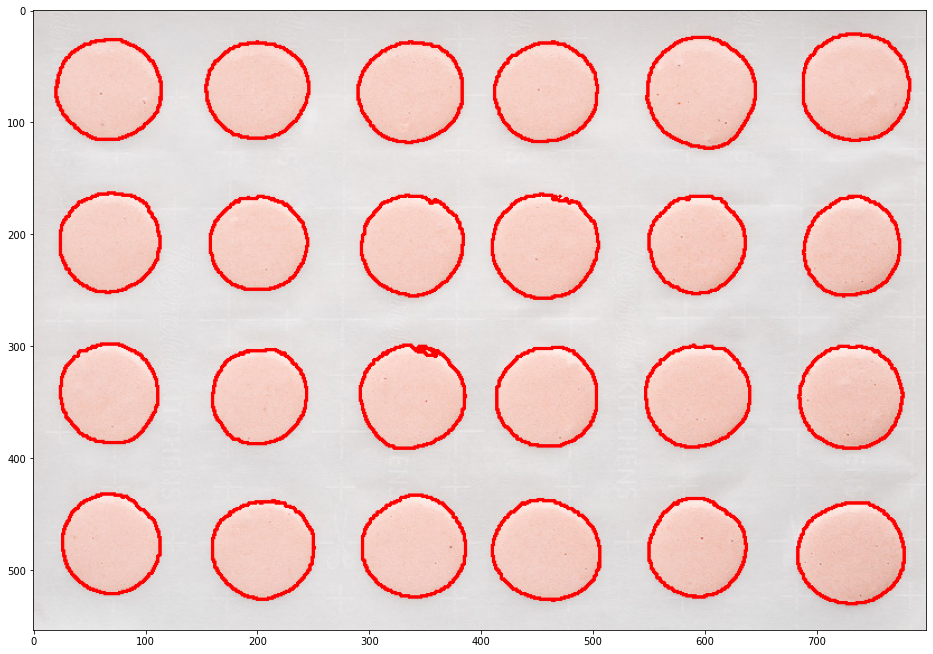

In [9]:
cnt, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Detected {len(cnt)} contours")

im_temp = copy.deepcopy(im)
LINE_COLOR = (255, 0, 0)
LINE_THICKNESS = 2
cv2.drawContours(im_temp, cnt, -1, LINE_COLOR, LINE_THICKNESS)

plt.figure(figsize=(16,16))
plt.imshow(im_temp)

## Keep Circular Contours

https://www.authentise.com/post/detecting-circular-shapes-using-contours

Median area of top 22 contours is 6516.5
Kept 24 of 25 contours


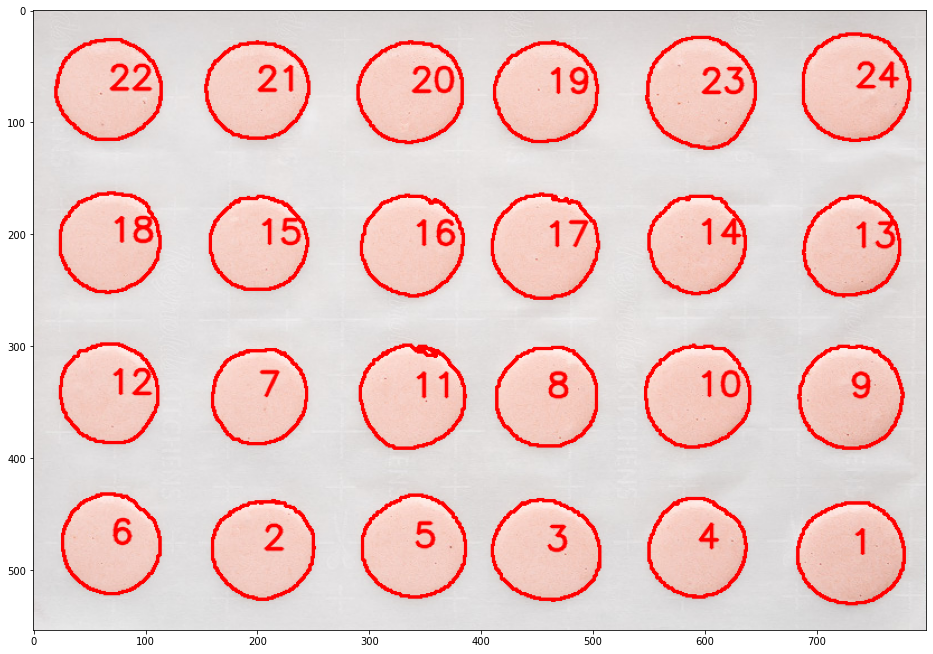

In [10]:
circles = []
MIN_POINTS = 8

# Calculate minimum area as half of mean area of 20 largest contours
TOP_N = 22
cnt_areas = [cv2.contourArea(x) for x in cnt]
cnt_areas_top_n = sorted(cnt_areas)[-TOP_N:]
cnt_areas_median = cnt_areas_top_n[TOP_N // 2]
MIN_AREA = 0.5 * cnt_areas_median
print(f"Median area of top {TOP_N} contours is {cnt_areas_median}")

for i in cnt:
    
    # Approximate polygon closest to each contour
    epsilon = 0.01 * cv2.arcLength(i, True)
    approx = cv2.approxPolyDP(i, epsilon, closed=True)
    
    # Keep only if approximate polygon is like a circle (>8 points + non negligible area)
    area = cv2.contourArea(i)
    if len(approx) > MIN_POINTS and area > MIN_AREA:
        circles.append(i)

print(f"Kept {len(circles)} of {len(cnt)} contours")

# Display results
im_temp = copy.deepcopy(im)
LINE_COLOR = (255, 0, 0)
LINE_THICKNESS = 2
cv2.drawContours(im_temp, circles, -1, LINE_COLOR, LINE_THICKNESS)

# Number contours
for idx, i in enumerate(circles):
    m = cv2.moments(i)
    x = int(m['m10'] / m['m00'])
    y = int(m['m01'] / m['m00'])
    cv2.putText(
        im_temp, 
        text=str(idx + 1), 
        org=(x, y),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=LINE_COLOR,
        thickness=LINE_THICKNESS,
        lineType=cv2.LINE_AA)
        

plt.figure(figsize=(16,16))
plt.imshow(im_temp)

## Simplest matching algorithm: Pairwise ordered by area

In [11]:
# Sort by area
circles_sorted = sorted(circles, key=lambda x: cv2.contourArea(x))

# List of pairs
odd_idx = list(range(0, len(circles_sorted) - 1, 2))
ordered_pairs = [(circles_sorted[x], circles_sorted[x+1]) for x in odd_idx]

print(f"{len(odd_idx) * 2} of {len(circles_sorted)} contours paired")

24 of 24 contours paired


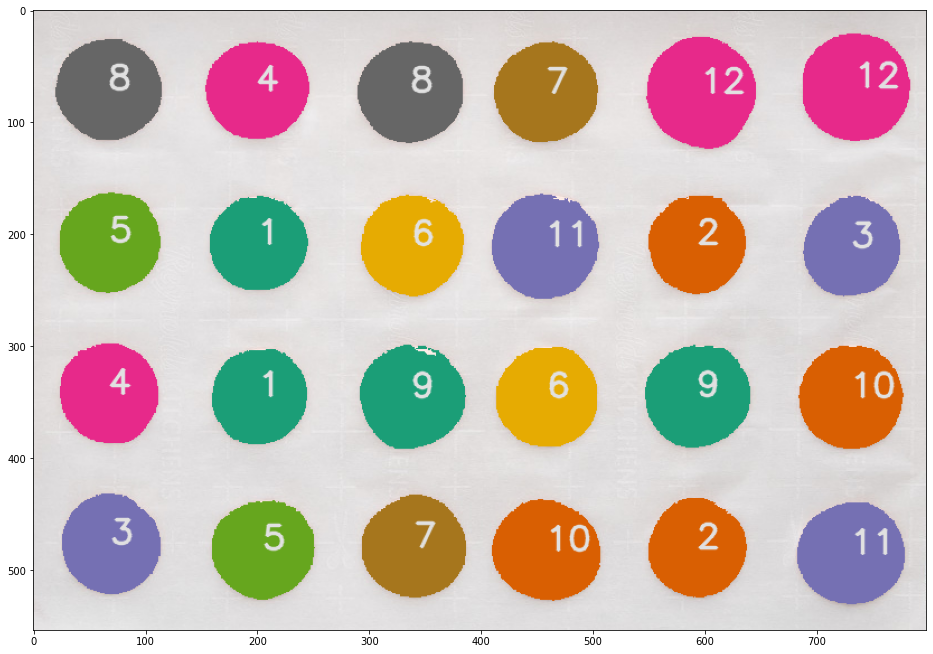

In [12]:
# Display results
im_temp = im.copy()
LINE_THICKNESS = 2
cmap = matplotlib.cm.get_cmap("Dark2")

for idx, i in enumerate(ordered_pairs):
    
    # Draw circle
    r, g, b, a = (int(x) for x in cmap(idx % cmap.N, bytes=True))
    line_color = (r, g, b)
    cv2.drawContours(im_temp, i, -1, line_color, thickness=cv2.FILLED)
    
    for j in i:
        # Label with pair idx
        m = cv2.moments(j)
        x = int(m['m10'] / m['m00'])
        y = int(m['m01'] / m['m00'])
        cv2.putText(
            im_temp, 
            text=str(idx + 1), 
            org=(x, y),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(225, 225, 225),
            thickness=LINE_THICKNESS,
            lineType=cv2.LINE_AA)
    
plt.figure(figsize=(16,16))
plt.imshow(im_temp)